In [2]:
import numpy as np
import torch
from torchvision.transforms import ToTensor
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
image_path = 'datasets/left.png'
image = Image.open(image_path)
image_np = np.asarray(image)
image_np_n = (image_np/255.0).astype(np.float32)

In [152]:
def adjust_dr(image, s, select_range = (0,1)):
    """adjust dynamic range HDR -> LDR simulation

    Args:
        image (Image.png): original image file .png
        s (float): scaling factor, scale intensity
        select_range (tuple, optional): set ldr dynamic range  Defaults to (0,1).

    Returns:
        _type_: numpy array image range (0,1)
    """
    if isinstance(image, Image.Image):
        to_tensor = ToTensor()
        image = to_tensor(image)
        
    if not torch.is_tensor(image):
        raise ValueError("Input image should be a Pytorch Tensor")
        
    if not torch.is_tensor(s):
        s = torch.tensor(s).to(image.device)
    
    a,b = select_range[0], select_range[1]
    
    image = (s * image - a) / (b - a)
    
    print("before clamp")
    print(torch.min(image), torch.max(image))
    
    image = torch.clamp(image , 0 ,1)
    
    print("after clamp")
    print(image.min(), image.max())

    return image

In [70]:
def poisson_gauss_noise(img, gauss_var=float(1e-6), poisson_scale=float(3.4e-4), iso=float(100.), clip=True):
    """
    Args:
        img (torch.Tensor): RGB image with float values in [0,1]
        gauss_var (float): Gaussian noise variance
        poisson_scale (float): Poisson noise scale
        iso (float): ISO level for noise scaling
        clip (bool): Whether to clip the output values to [0,1]

    Returns:
        torch.Tensor: An image with Poisson Gauss noise model.
    """
    
    # Ensure the input image is a tensor
    if not torch.is_tensor(img):
        raise ValueError("Input image should be a PyTorch Tensor.")
    
    # Rescale the noise parameters to take into account the ISO
    gauss_std = torch.sqrt(torch.tensor(gauss_var)) * iso / 100.0
    poisson_scale = torch.tensor(poisson_scale) * iso / 100.0
    
    # Move noise parameters to the same device as the image tensor
    gauss_std = gauss_std.to(img.device)
    poisson_scale = poisson_scale.to(img.device)
    
    # Add Poisson noise
    im_poisson = torch.poisson(img / poisson_scale) * poisson_scale
    
    # Add Gaussian noise
    im = im_poisson + gauss_std * torch.rand_like(img)
    
    if clip:
        im = torch.clamp(im, 0, 1)
        
    return im

In [93]:
def denormalized_image(image, s, select_range=(0,1)):
    """denormalize image to input to depth estimation model

    Args:
        image (_type_): original image file
        s (_type_): scaling factor
        select_range (tuple, optional): _description_. Defaults to (0,1).

    Returns:
        torch tensor : denormalized image tensor 
    """
    if not torch.is_tensor(image):
        raise ValueError("Input image should be a Pytorch Tensor")
    
    if not torch.is_tensor(s):
        s = torch.tensor(s).to(image.device)
    
    a,b = select_range[0], select_range[1]
    
    image_denormalized = (b-a) * image + a
    image_denormalized = image_denormalized / s
    
    return image_denormalized

before clamp
tensor(0.) tensor(3.3333)
after clamp
tensor(0.) tensor(1.)


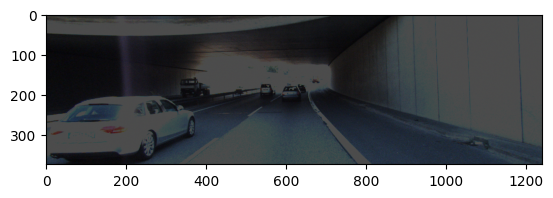

In [174]:
to_tensor = ToTensor()
image2 = to_tensor(image)

image2

image_torch = adjust_dr(image2, 2, (0,0.6))
image_torch = poisson_gauss_noise(image_torch, iso = 100)
denom_image = denormalized_image(image_torch, 2, (0,0.6))

plt.imshow(denom_image.permute(1,2,0).numpy())

In [114]:
def cal_dynamic_range(image_np_n, exp):
    if image_np_n[0,0,0] <=1:
        mean_intensity = np.mean(image_np_n)
        std_intensity = np.std(image_np_n)
        
        a = mean_intensity - exp * std_intensity
        b = mean_intensity + exp * std_intensity
    else:
        raise ValueError("Input image must be normalized between [0,1]")
    
    return a,b

0.1523460477590561 0.44644960463047023


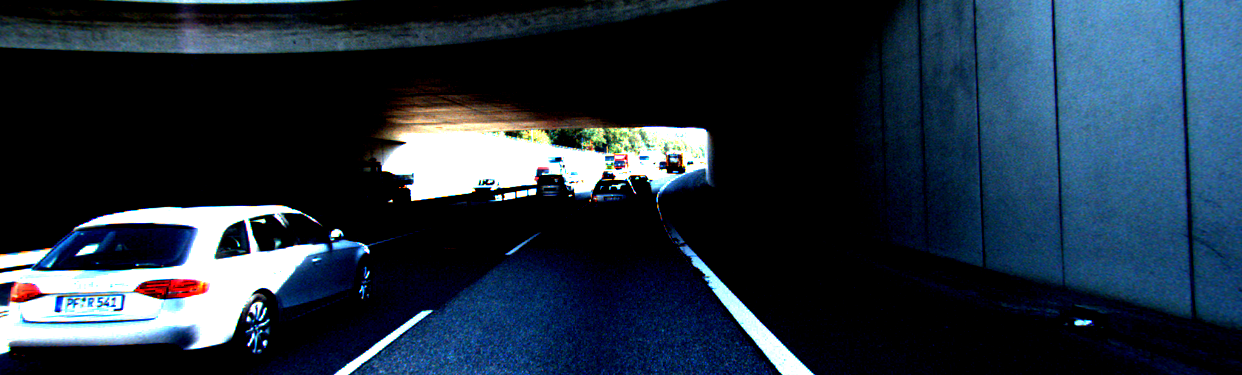

In [116]:
a,b = cal_dynamic_range(image_np_n, 0.6)
print(a,b)
image_test = adjust_dr(image_np, 0.6, (a,b))
Image.fromarray((image_test*255).astype(np.uint8))

In [167]:
import random

def generate_random_value():
    return random.uniform(0.1, 10)

# 함수 호출하여 랜덤 값 생성
random_value = generate_random_value()
print(random_value)


5.482335501838498


## opt_einsum test

In [10]:
import numpy as np
import opt_einsum as oe
import time

A = np.random.randn(2,2)
B = np.random.randn(2,5)
C = np.random.randn(5,3)

start_time = time.time()
result = oe.contract('ik,kj,jl -> il', A,B,C)
end_time = time.time()
print(end_time-start_time)
result

0.0002009868621826172


array([[ 2.94833352,  3.64826884, -4.31735018],
       [ 2.84848787, -0.73604561, -1.5388152 ]])

In [11]:
start_time = time.time()
result = A@B@C
end_time = time.time()
print(end_time-start_time)
result

3.933906555175781e-05


array([[ 2.94833352,  3.64826884, -4.31735018],
       [ 2.84848787, -0.73604561, -1.5388152 ]])

In [2]:
listh = ['a','b','c']
temp = list(zip(*listh))
temp

[('a', 'b', 'c')]

In [6]:
a = [1,3,5]
b = [2,4,6]
listh = [a,b]
temp = list(zip(*listh))
temp

[(1, 2), (3, 4), (5, 6)]